In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from scipy.signal import wiener

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from umap import UMAP

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import (
    VGG16, VGG19, ResNet50, InceptionV3, Xception, MobileNetV2, 
    DenseNet121, EfficientNetB0, InceptionResNetV2
)
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Average
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision

2025-07-26 06:14:44.355740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753510484.729263      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753510484.838366      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# --- 1. CONFIGURATION AND SETUP ---

# --- Dataset and Output Paths ---

In [3]:
SOURCE_DIR = '/kaggle/input/plantvillage-dataset/color'
BASE_DIR = '/kaggle/working/crop_dataset_split'
OUTPUT_DIR = '/kaggle/working/model_outputs' # Directory to save all results
Data_Selector = ['Peach___', 'Pepper,_bell___', 'Strawberry___']

CLASS_MAP = {
    'Peach___': 'peach',
    'Pepper,_bell___': 'bell_pepper',
    'Strawberry___': 'strawberry'
    # Add other classes here following the same pattern
}

# --- Model and Training Parameters ---

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 6 
EPOCHS = 30
EARLY_STOPPING_PATIENCE = 10


# --- Preprocessing Toggles ---

In [5]:
APPLY_CLAHE = False
APPLY_GAUSSIAN_BLUR = False 
APPLY_MEDIAN_FILTER = False
APPLY_WIENER_FILTER = False
APPLY_HISTOGRAM_EQUALIZATION = False
APPLY_LAPLACIAN_FILTER = False
APPLY_AVERAGE_FILTER = False
APPLY_SOBEL_FILTER = False
APPLY_CANNY_FILTER = False

In [6]:
def setup_directories():
    
    if os.path.exists(BASE_DIR):
        print(f"Directory '{BASE_DIR}' already exists. Deleting it to recreate...")
        shutil.rmtree(BASE_DIR)
    
    print("Creating new train/val/test directories...")
    train_dir = os.path.join(BASE_DIR, 'train')
    val_dir = os.path.join(BASE_DIR, 'val')
    test_dir = os.path.join(BASE_DIR, 'test')
    
    os.makedirs(train_dir)
    os.makedirs(val_dir)
    os.makedirs(test_dir)
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    try:
        # Filter for directories that start with one of the prefixes from our map
        class_names = [
            d for d in os.listdir(SOURCE_DIR)
            if os.path.isdir(os.path.join(SOURCE_DIR, d)) and d.startswith(tuple(CLASS_MAP.keys()))
        ]
        
        if not class_names:
            print(f"ERROR: No matching class directories found in '{SOURCE_DIR}'.")
            print(f"Searched for directories starting with: {list(CLASS_MAP.keys())}")
            return

        print(f"Found {len(class_names)} matching class directories to process.")

        for class_name in class_names:
            print(f"Processing '{class_name}'...")
            
            # --- CHANGE 2: New name cleaning logic using the CLASS_MAP ---
            cleaned_name = class_name
            for prefix, clean_crop_name in CLASS_MAP.items():
                if class_name.startswith(prefix):
                    # Get the part after the prefix (e.g., 'healthy', 'Bacterial_spot')
                    status = class_name.replace(prefix, '', 1)
                    # Clean the status: replace underscores with spaces and make it lowercase
                    cleaned_status = status.replace('_', ' ').lower()
                    # Combine the clean crop name and the status
                    cleaned_name = f"{clean_crop_name} {cleaned_status}"
                    break
            
            print(f"  -> Cleaned name will be: '{cleaned_name}'")

            # Create subdirectories using the new cleaned name
            for d in [train_dir, val_dir, test_dir]:
                os.makedirs(os.path.join(d, cleaned_name), exist_ok=True)
            
            # Get all file paths from the source class directory
            src_path = os.path.join(SOURCE_DIR, class_name)
            files = [f for f in os.listdir(src_path) if os.path.isfile(os.path.join(src_path, f))]
            
            np.random.shuffle(files)
            
            # Split files into train/val/test sets
            train_split, val_split = 0.7, 0.15
            train_end = int(len(files) * train_split)
            val_end = train_end + int(len(files) * val_split)
            train_files, val_files, test_files = files[:train_end], files[train_end:val_end], files[val_end:]
            
            # Copy files into the correctly named directories
            for f in train_files:
                shutil.copy(os.path.join(src_path, f), os.path.join(train_dir, cleaned_name, f))
            for f in val_files:
                shutil.copy(os.path.join(src_path, f), os.path.join(val_dir, cleaned_name, f))
            for f in test_files:
                shutil.copy(os.path.join(src_path, f), os.path.join(test_dir, cleaned_name, f))

        print("\nData splitting and directory setup complete.")
        print(f"Dataset created at: '{BASE_DIR}'")

    except FileNotFoundError:
        print(f"ERROR: Source directory not found at '{SOURCE_DIR}'. Please check the path.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Run the Setup ---
setup_directories()

# You can now use these variables to point to your new dataset
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')
test_dir = os.path.join(BASE_DIR, 'test')

Creating new train/val/test directories...
Found 6 matching class directories to process.
Processing 'Strawberry___Leaf_scorch'...
  -> Cleaned name will be: 'strawberry leaf scorch'
Processing 'Peach___healthy'...
  -> Cleaned name will be: 'peach healthy'
Processing 'Peach___Bacterial_spot'...
  -> Cleaned name will be: 'peach bacterial spot'
Processing 'Pepper,_bell___healthy'...
  -> Cleaned name will be: 'bell_pepper healthy'
Processing 'Strawberry___healthy'...
  -> Cleaned name will be: 'strawberry healthy'
Processing 'Pepper,_bell___Bacterial_spot'...
  -> Cleaned name will be: 'bell_pepper bacterial spot'

Data splitting and directory setup complete.
Dataset created at: '/kaggle/working/crop_dataset_split'


# --- 2. PREPROCESSING FUNCTIONS ---

In [7]:
def apply_clahe(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged_channels = cv2.merge([cl, a, b])
    return cv2.cvtColor(merged_channels, cv2.COLOR_LAB2RGB)

def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_median_blur(image):
    return cv2.medianBlur(image, 5)

def apply_wiener_filter(image):
    img_float = image.astype(np.float64) / 255.0
    filtered_channels = [wiener(channel) for channel in cv2.split(img_float)]
    filtered_image = cv2.merge(filtered_channels)
    return (np.clip(filtered_image, 0, 1) * 255).astype(np.uint8)

def apply_histogram_equalization(image):
    img_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    img_ycrcb[:, :, 0] = cv2.equalizeHist(img_ycrcb[:, :, 0])
    return cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2RGB)

def apply_laplacian_filter(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    abs_laplacian = np.absolute(laplacian)
    return np.uint8(abs_laplacian)

def apply_average_filter(image):
    return cv2.blur(image, (5, 5))

def apply_sobel_filter(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = np.sqrt(sobelx**2 + sobely**2)
    sobel_norm = cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX)
    sobel_uint8 = np.uint8(sobel_norm)
    return cv2.cvtColor(sobel_uint8, cv2.COLOR_GRAY2RGB)

def apply_canny_filter(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

def get_preprocessing_function(model_specific_preprocess_input):
    def master_preprocessing_function(image):
        if model_specific_preprocess_input is None:
            return image / 255.0
            
        processed_image = image.astype('uint8')
        if APPLY_WIENER_FILTER: processed_image = apply_wiener_filter(processed_image)
        if APPLY_MEDIAN_FILTER: processed_image = apply_median_blur(processed_image)
        if APPLY_AVERAGE_FILTER: processed_image = apply_average_filter(processed_image)
        if APPLY_GAUSSIAN_BLUR: processed_image = apply_gaussian_blur(processed_image)
        if APPLY_CLAHE: processed_image = apply_clahe(processed_image)
        if APPLY_HISTOGRAM_EQUALIZATION: processed_image = apply_histogram_equalization(processed_image)
        if APPLY_LAPLACIAN_FILTER: processed_image = apply_laplacian_filter(processed_image)
        if APPLY_SOBEL_FILTER: processed_image = apply_sobel_filter(processed_image)
        if APPLY_CANNY_FILTER: processed_image = apply_canny_filter(processed_image)
        processed_image = processed_image.astype('float32')
        return model_specific_preprocess_input(processed_image)
    return master_preprocessing_function

# --- Function to Create the Custom CNN Model ---

In [8]:
def create_custom_cnn(input_shape, num_classes):
    """Builds and returns the user-defined custom CNN model."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, (1, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(3, 3),
        layers.Conv2D(32, (1, 1), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(3, 3),
        layers.Conv2D(64, (1, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(3, 3),
        layers.Conv2D(16, (1, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.BatchNormalization(),
        # Add a feature extractor layer name for Grad-CAM and feature projection
        layers.GlobalAveragePooling2D(name='feature_extractor_layer'),
        layers.Dense(num_classes, activation='softmax')
    ])
    print("--- Custom CNN Model Summary ---")
    model.summary()
    return model

# --- 3. VISUALIZATION AND REPORTING FUNCTIONS ---

In [9]:
def plot_training_history(history, model_name, save_dir):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} - Accuracy'); axes[0].legend()
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} - Loss'); axes[1].legend()
    axes[2].plot(history.history['precision'], label='Train Precision')
    axes[2].plot(history.history['val_precision'], label='Validation Precision')
    axes[2].set_title(f'{model_name} - Precision'); axes[2].legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_training_history.png'))
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, model_name, save_dir):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
    plt.show()

def plot_roc_pr_curves(y_true_bin, y_pred_prob, class_names, model_name, save_dir):
    n_classes = len(class_names)
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        axes[0].plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    axes[0].plot([0, 1], [0, 1], 'k--'); axes[0].set_title(f'{model_name} - ROC Curve'); axes[0].legend()
    precision, recall, pr_auc = {}, {}, {}
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        axes[1].plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {pr_auc[i]:.2f})')
    axes[1].set_title(f'{model_name} - Precision-Recall Curve'); axes[1].legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_roc_pr_curves.png'))
    plt.show()

def plot_projections(features, labels, class_names, model_name, save_dir):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1)).fit_transform(features)
    df_tsne = pd.DataFrame({'x': tsne[:, 0], 'y': tsne[:, 1], 'label': [class_names[l] for l in labels]})
    sns.scatterplot(data=df_tsne, x='x', y='y', hue='label', ax=axes[0], palette='viridis').set_title(f'{model_name} - t-SNE')
    umap_proj = UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(features)
    df_umap = pd.DataFrame({'x': umap_proj[:, 0], 'y': umap_proj[:, 1], 'label': [class_names[l] for l in labels]})
    sns.scatterplot(data=df_umap, x='x', y='y', hue='label', ax=axes[1], palette='viridis').set_title(f'{model_name} - UMAP')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_projections.png'))
    plt.show()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    img = cv2.imread(img_path); img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])); heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.clip(heatmap * alpha + img, 0, 255).astype('uint8')
    cv2.imwrite(cam_path, superimposed_img)


def visualize_class_maps(model, last_conv_layer_name, master_preprocessor, model_name, save_dir):
    class_names = sorted(os.listdir(test_dir))
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        img_path = os.path.join(test_dir, class_name, os.listdir(os.path.join(test_dir, class_name))[0])
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        img_preprocessed = master_preprocessor(img_array.copy())
        img_for_model = np.expand_dims(img_preprocessed, axis=0)
        heatmap = make_gradcam_heatmap(img_for_model, model, last_conv_layer_name)
        cam_path = os.path.join(save_dir, f'{model_name}_gradcam_{class_name}.png')
        save_and_display_gradcam(img_path, heatmap, cam_path)
        ax = plt.subplot(3, 2, i + 1); ax.imshow(cv2.cvtColor(cv2.imread(cam_path), cv2.COLOR_BGR2RGB)); ax.set_title(f'Grad-CAM: {class_name}'); ax.axis("off")
    plt.tight_layout(); plt.show()



def visualize_predictions(y_true, y_pred, test_generator, class_names, model_name, save_dir, num_examples_per_class=2):
    filenames = test_generator.filenames
    examples_shown = {name: 0 for name in class_names}
    total_images_to_plot = num_examples_per_class * len(class_names)
    fig, axes = plt.subplots(nrows=num_examples_per_class, ncols=len(class_names), figsize=(18, 5 * num_examples_per_class), squeeze=False)
    fig.suptitle(f'{model_name} - Prediction Samples', fontsize=20)
    plotted_count = 0
    for i in range(len(filenames)):
        if plotted_count >= total_images_to_plot: break
        true_label_idx = y_true[i]
        true_label_name = class_names[true_label_idx]
        if examples_shown[true_label_name] < num_examples_per_class:
            pred_label_idx = y_pred[i]
            pred_label_name = class_names[pred_label_idx]
            img_path = os.path.join(test_dir, filenames[i])
            img = load_img(img_path)
            row = examples_shown[true_label_name]
            col = true_label_idx
            ax = axes[row, col]
            ax.imshow(img)
            ax.axis('off')
            title_color = 'green' if pred_label_name == true_label_name else 'red'
            ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", color=title_color, fontsize=12)
            examples_shown[true_label_name] += 1
            plotted_count += 1
    for ax in axes.flatten():
        if not ax.images:
            ax.axis('off')
    fig.tight_layout(rect=[0, 0, 1, 0.96], h_pad=5.0)
    plt.savefig(os.path.join(save_dir, f'{model_name}_prediction_samples.png'))
    plt.show()

# --- 4. MAIN TRAINING & EVALUATION LOOP ---


==================== Training and Evaluating: CustomCNN ====================
Found 4684 images belonging to 6 classes.
Found 1002 images belonging to 6 classes.
Found 1011 images belonging to 6 classes.


I0000 00:00:1753510580.930390      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753510580.931141      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


--- Custom CNN Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 16)       │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 2, 2, 16)       │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor_layer         │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,822 (479.77 KB)

 Trainable params: 122,406 (478.15 KB)

 Non-trainable params: 416 (1.62 KB)

I0000 00:00:1753510589.994230     118 service.cc:148] XLA service 0x7b1dc811b570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753510589.995920     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753510589.995953     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753510590.798731     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/147 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2148 - loss: 1.8717 - precision: 0.2696     

I0000 00:00:1753510596.868847     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.5125 - loss: 1.2701 - precision: 0.7529 - val_accuracy: 0.2595 - val_loss: 1.8158 - val_precision: 0.0000e+00

--- Loading best model from '/kaggle/working/model_outputs/CustomCNN/CustomCNN_best.keras' for evaluation ---

--- Generating visualizations for CustomCNN ---


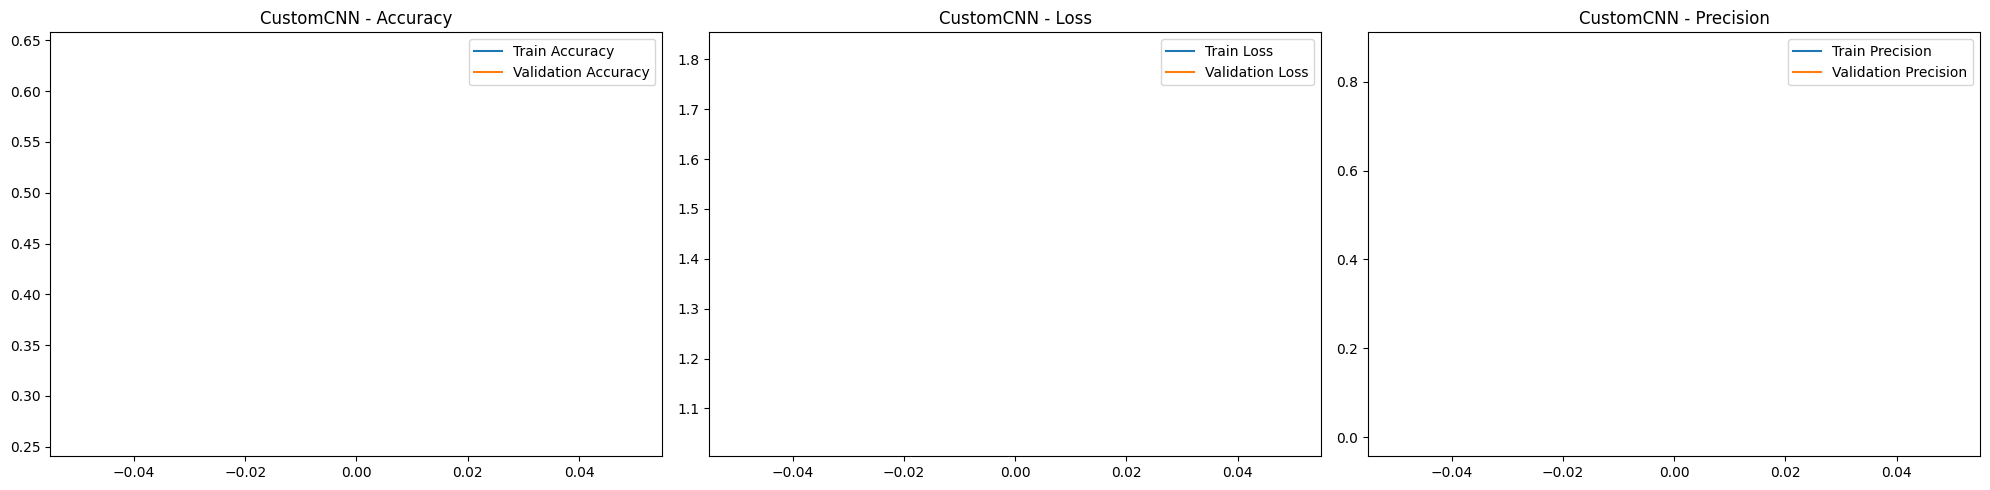

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step

Classification Report for CustomCNN:
                            precision    recall  f1-score   support

bell_pepper bacterial spot       0.00      0.00      0.00       151
       bell_pepper healthy       0.25      0.58      0.35       223
      peach bacterial spot       0.68      0.21      0.32       346
             peach healthy       0.00      0.00      0.00        55
        strawberry healthy       0.10      0.55      0.17        69
    strawberry leaf scorch       0.00      0.00      0.00       167

                  accuracy                           0.24      1011
                 macro avg       0.17      0.22      0.14      1011
              weighted avg       0.29      0.24      0.20      1011



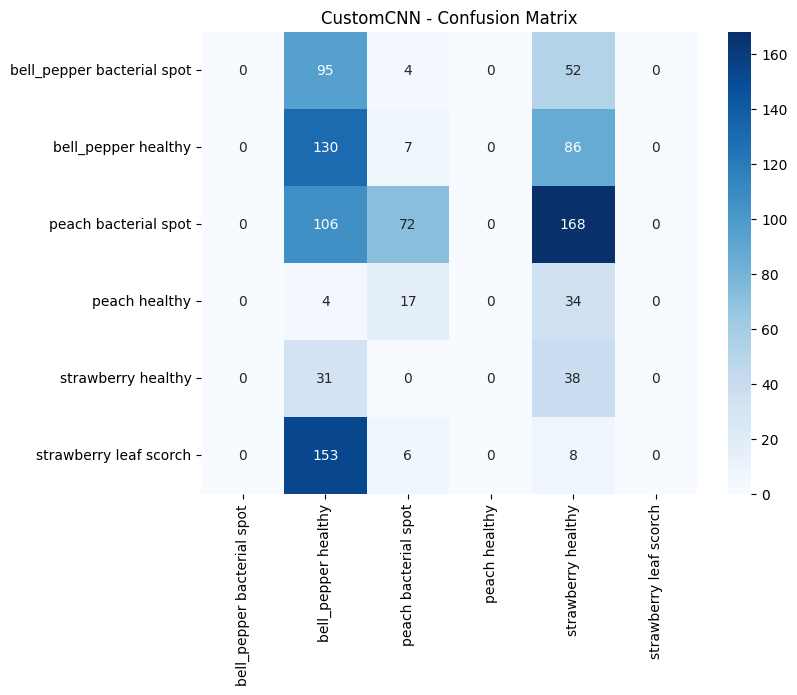

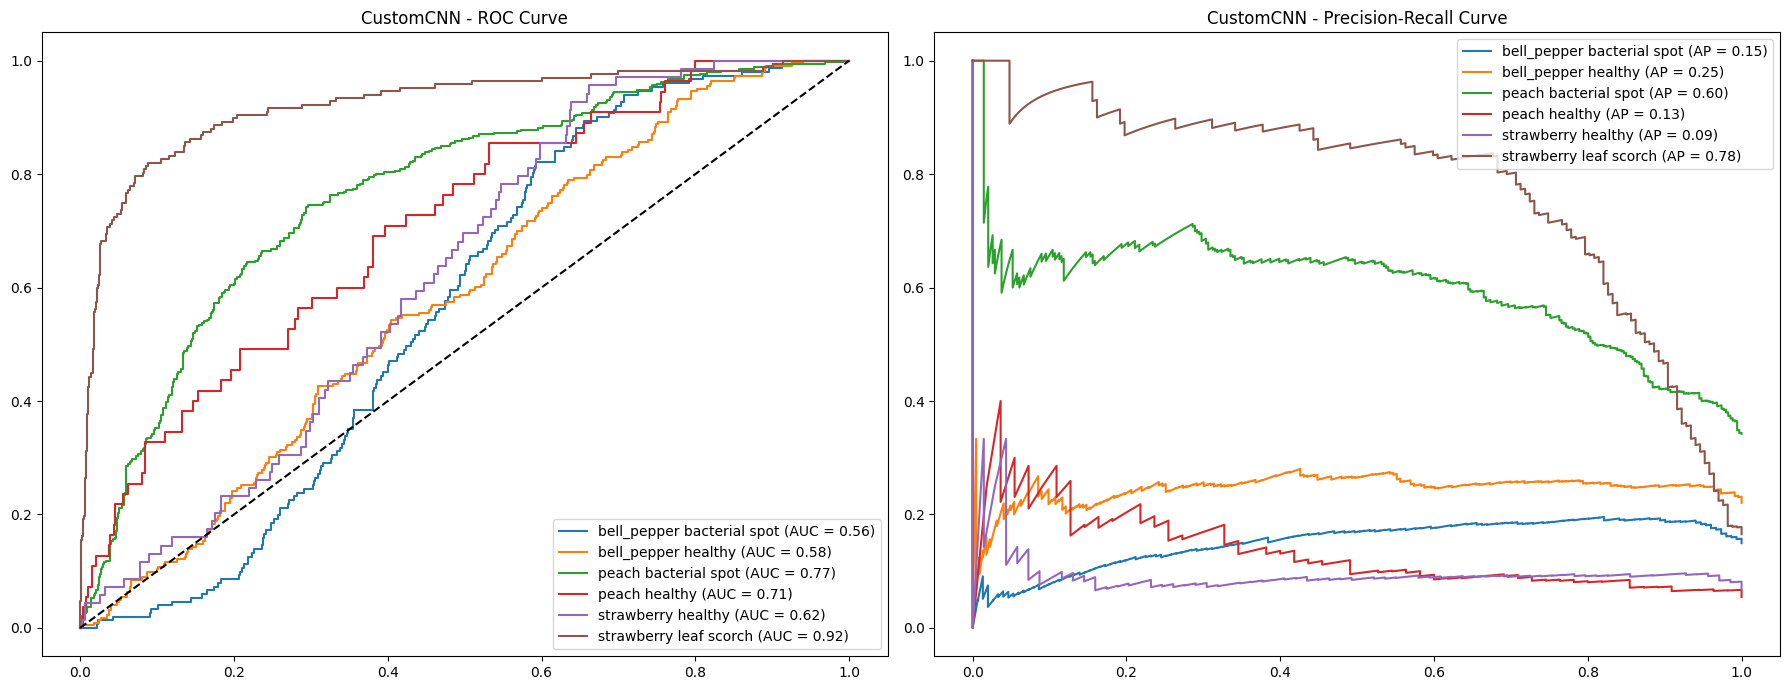

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


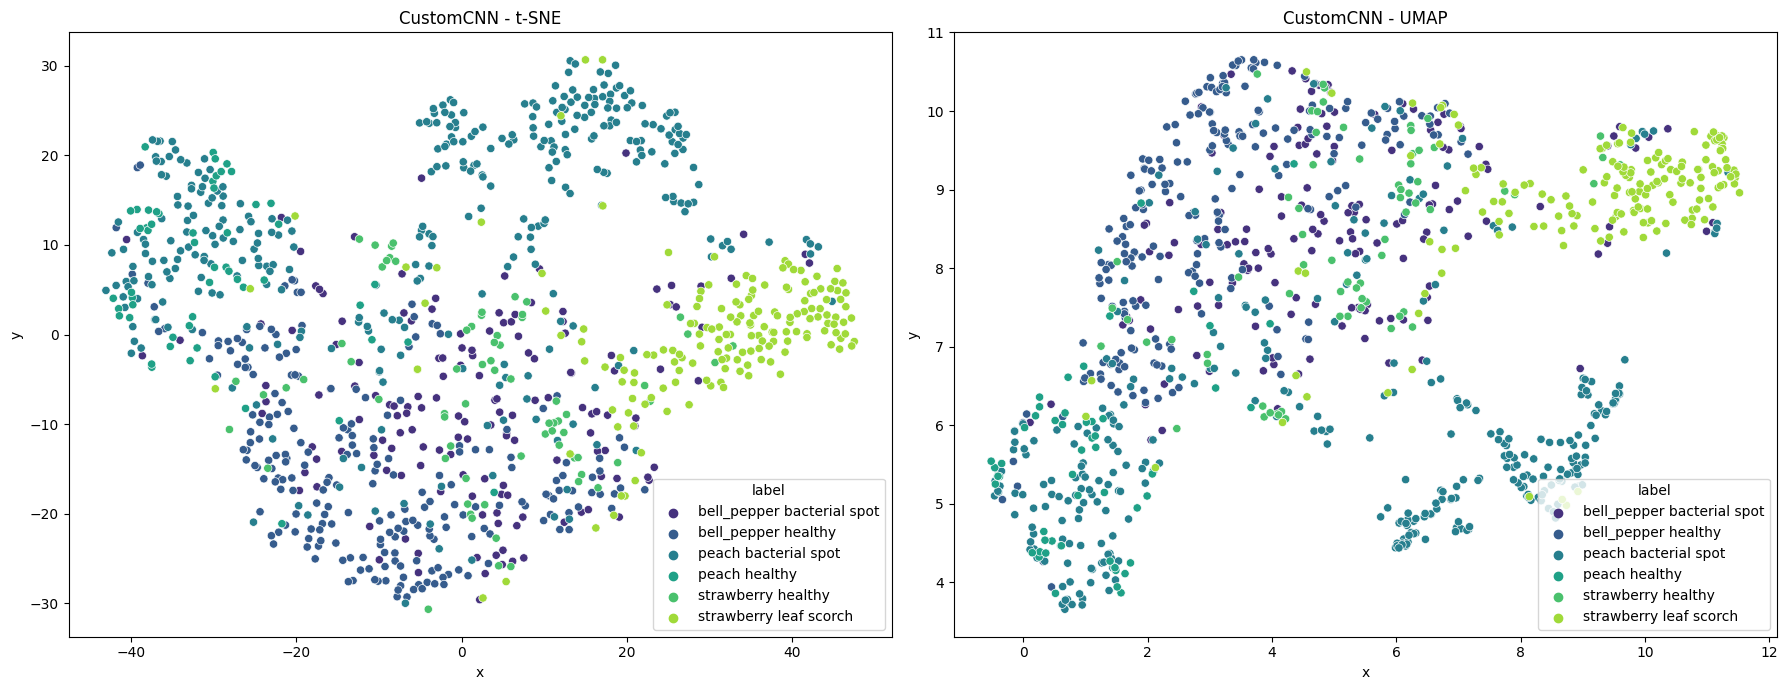

Could not find a convolutional layer for Grad-CAM in CustomCNN. Skipping.


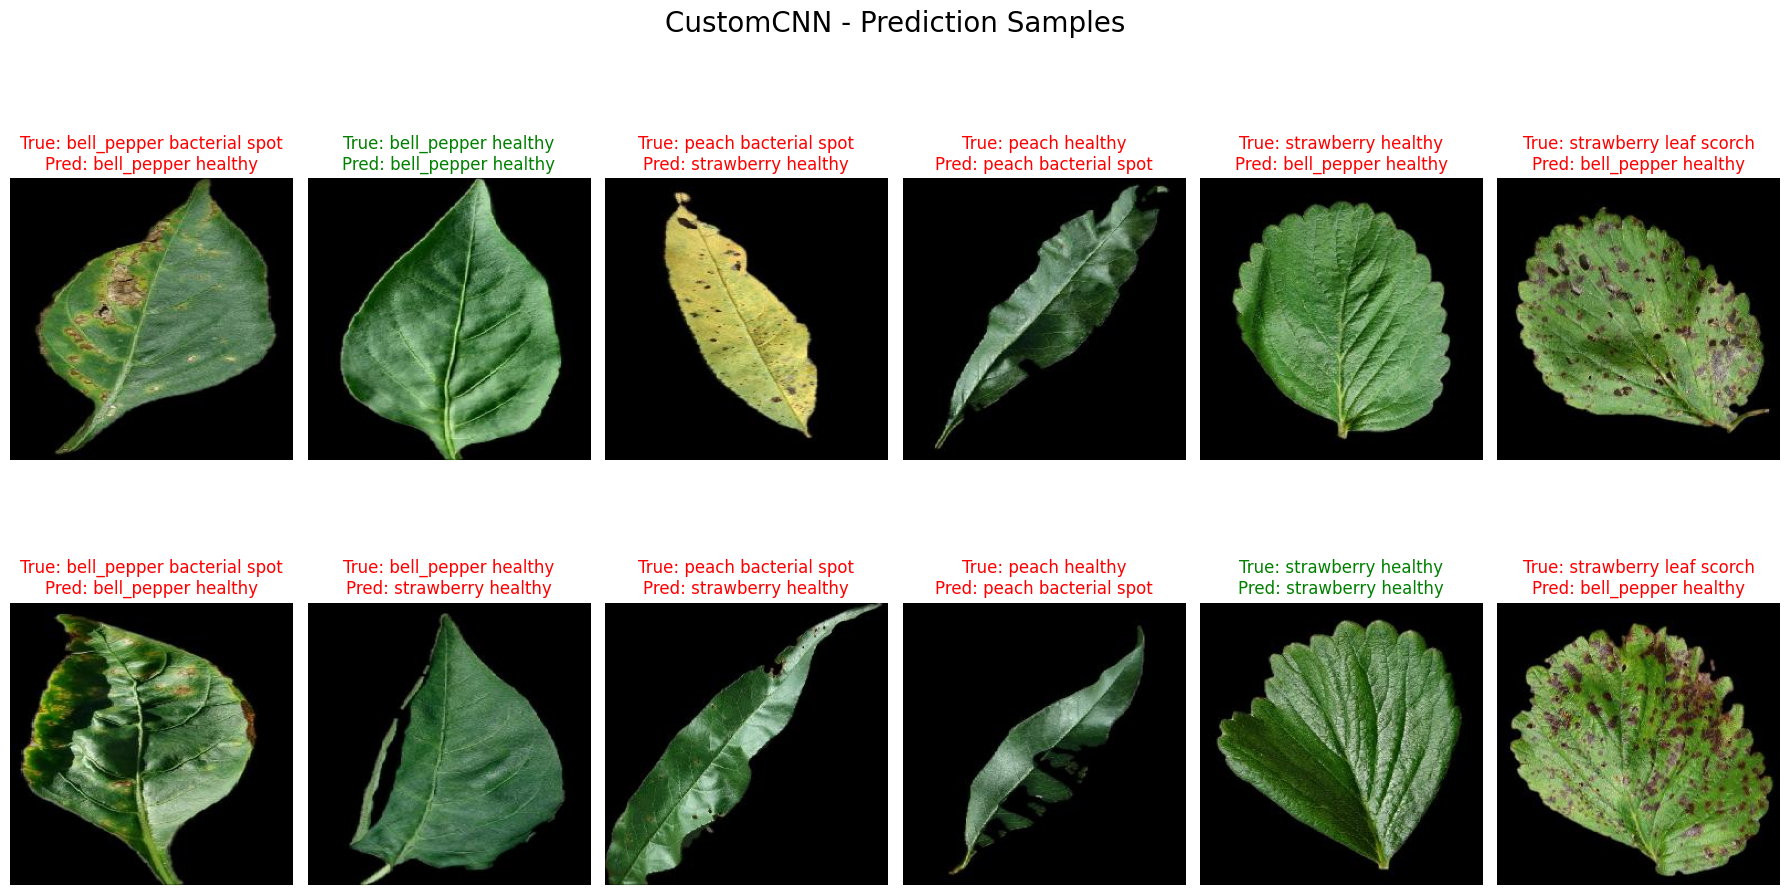


Finished processing CustomCNN. Results saved to /kaggle/working/model_outputs/CustomCNN

==================== Training and Evaluating: VGG16 ====================
Found 4684 images belonging to 6 classes.
Found 1002 images belonging to 6 classes.
Found 1011 images belonging to 6 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 88s 502ms/step - accuracy: 0.2939 - loss: 3.6674 - precision: 0.3043 - val_accuracy: 0.7725 - val_loss: 0.6655 - val_precision: 0.8298

--- Loading best model from '/kaggle/working/model_outputs/VGG16/VGG16_best.keras' for evaluation ---

--- Generating visualizations for VGG16 ---


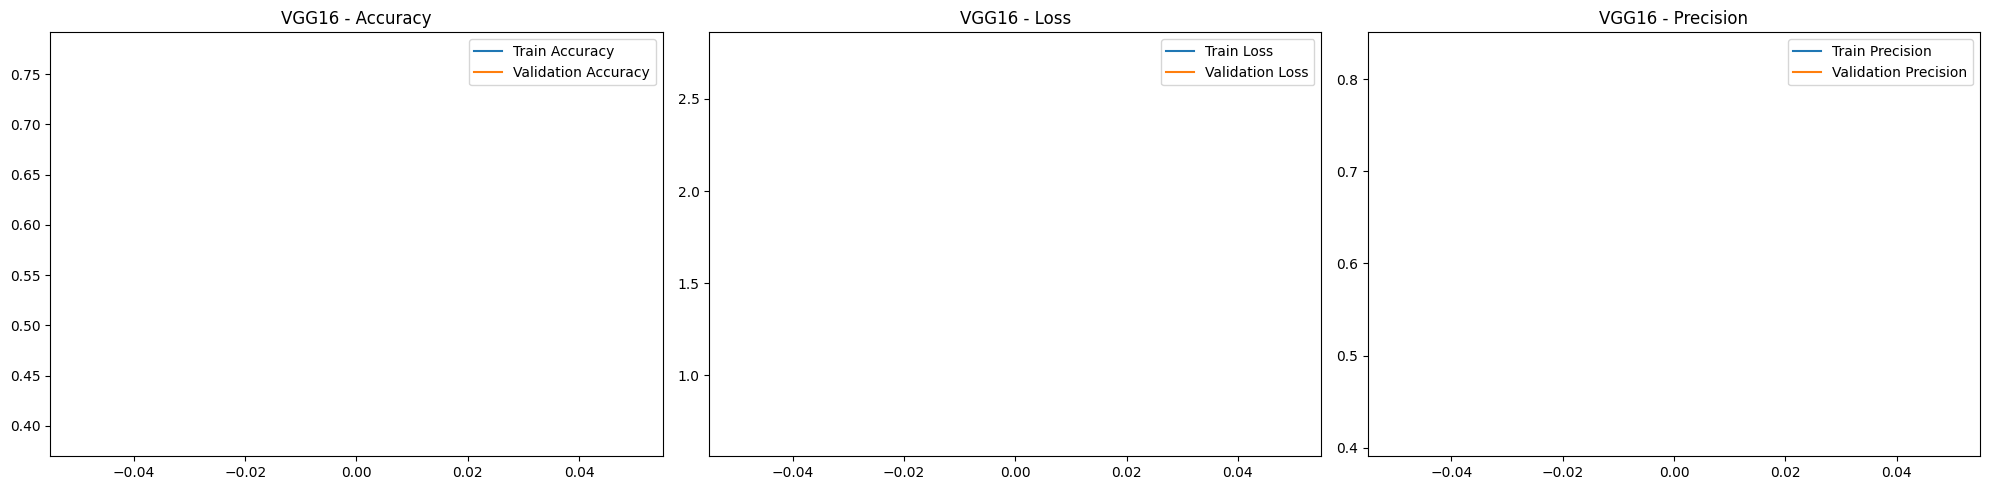

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 459ms/step

Classification Report for VGG16:
                            precision    recall  f1-score   support

bell_pepper bacterial spot       0.58      0.48      0.52       151
       bell_pepper healthy       0.78      0.81      0.80       223
      peach bacterial spot       0.81      0.92      0.86       346
             peach healthy       1.00      0.02      0.04        55
        strawberry healthy       0.88      0.91      0.89        69
    strawberry leaf scorch       0.85      0.93      0.89       167

                  accuracy                           0.78      1011
                 macro avg       0.81      0.68      0.67      1011
              weighted avg       0.79      0.78      0.76      1011



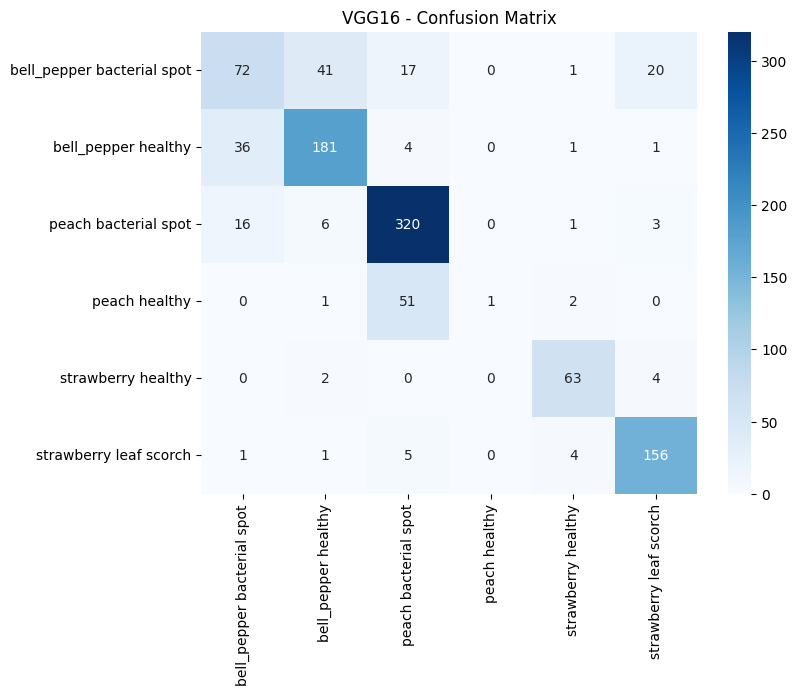

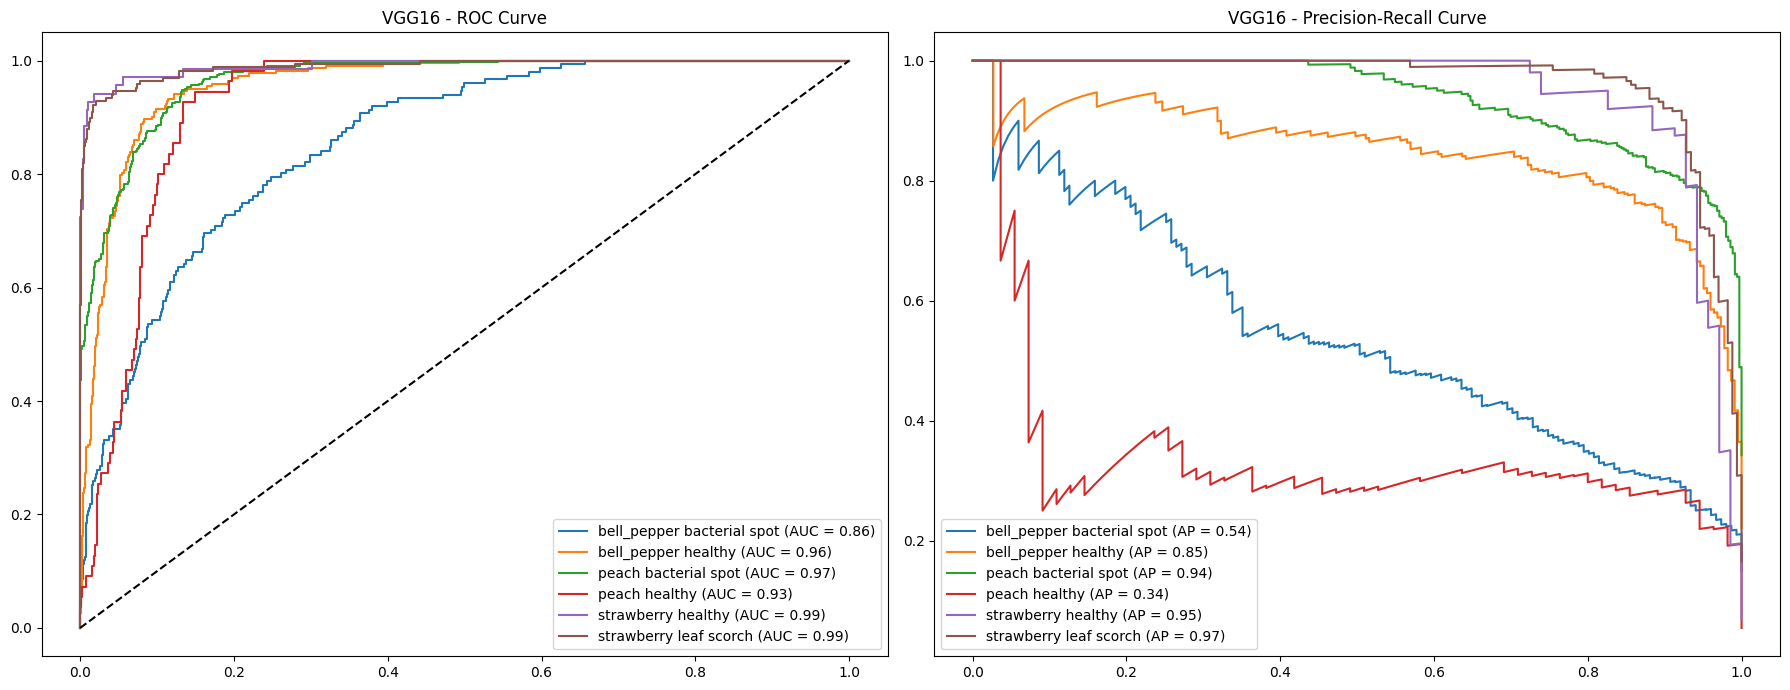

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step


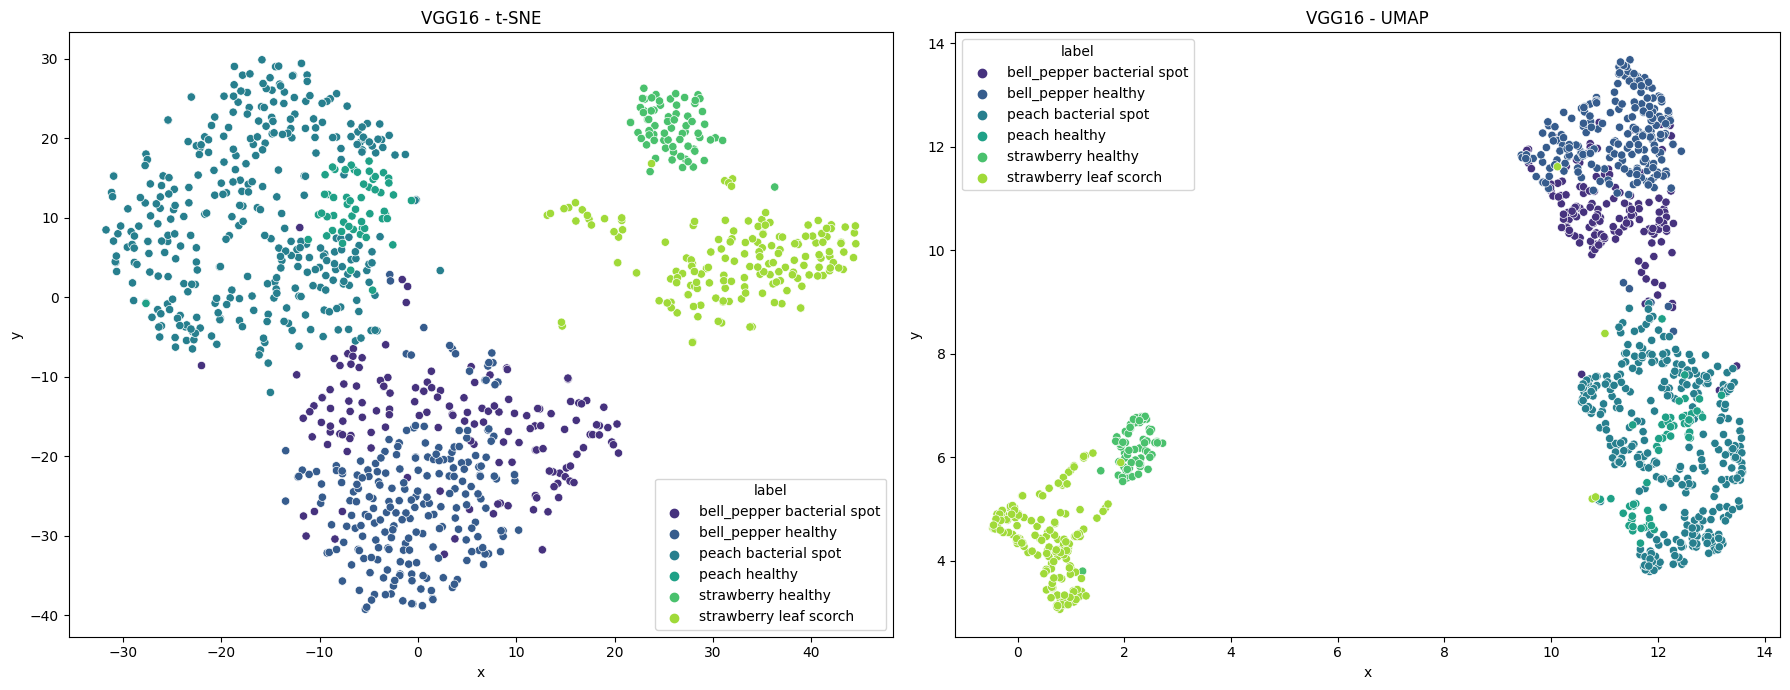

Generating Grad-CAM maps for VGG16 using layer: block5_conv3


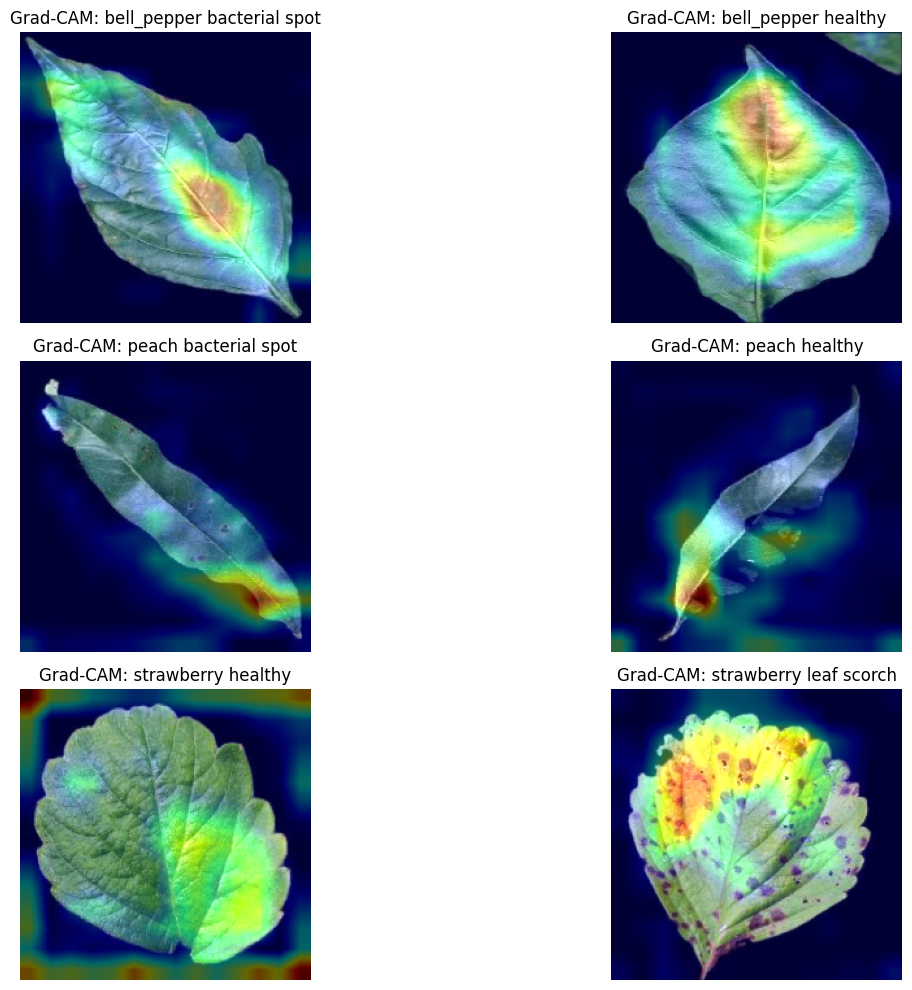

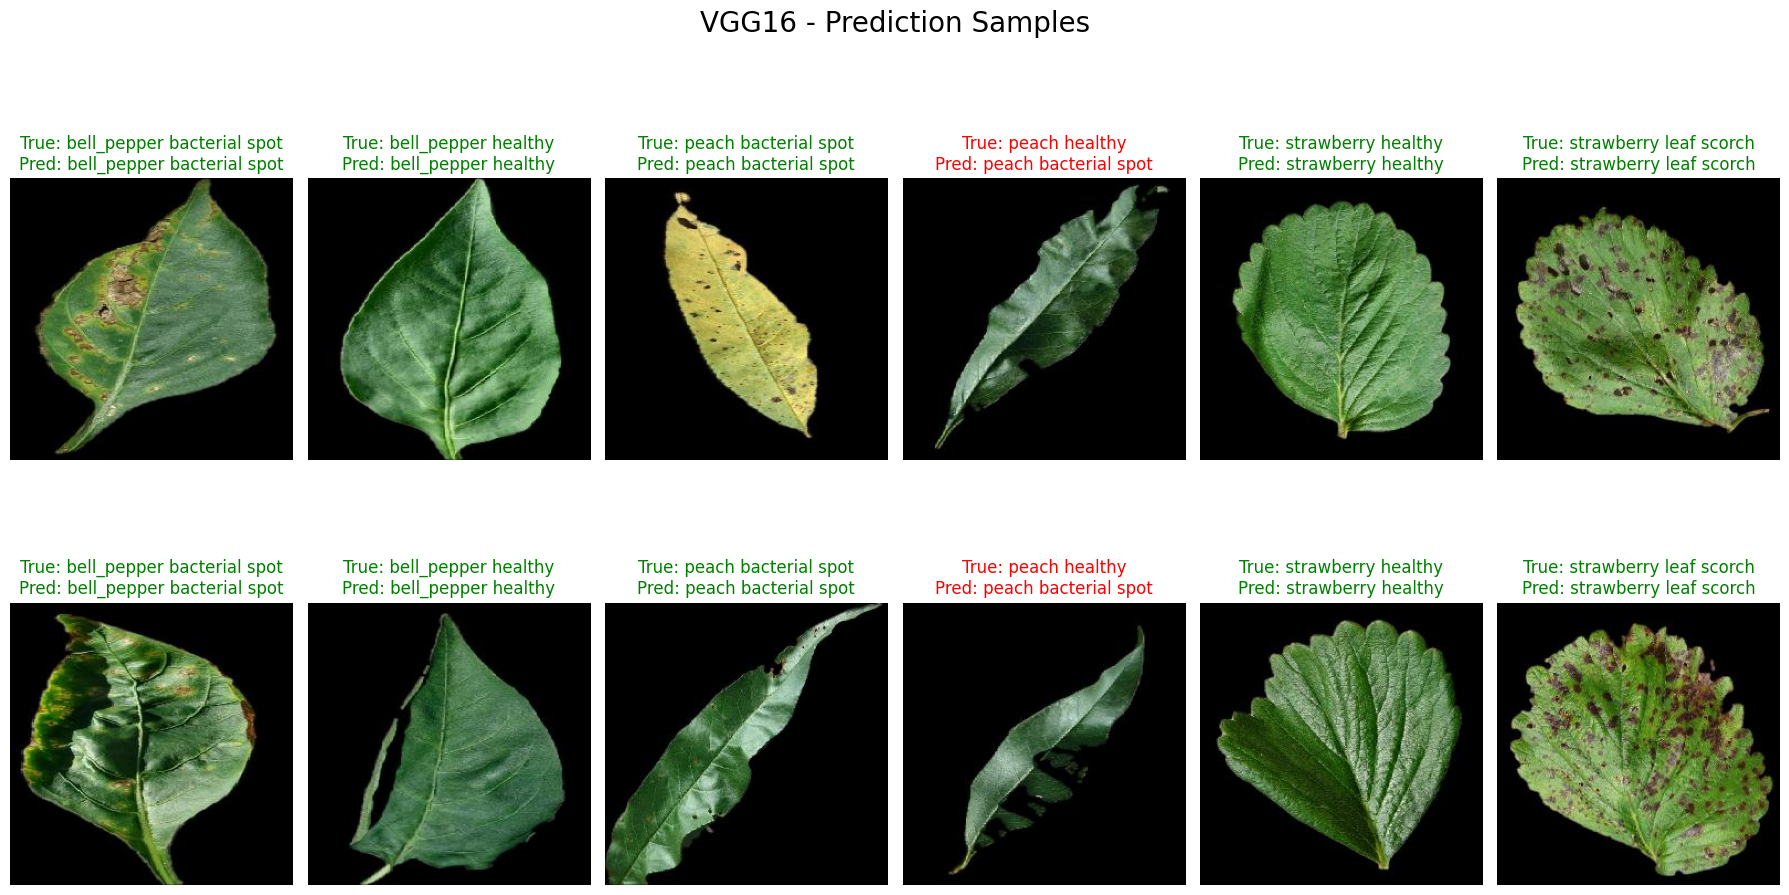


Finished processing VGG16. Results saved to /kaggle/working/model_outputs/VGG16

==================== Training and Evaluating: VGG19 ====================
Found 4684 images belonging to 6 classes.
Found 1002 images belonging to 6 classes.
Found 1011 images belonging to 6 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 30/147 ━━━━━━━━━━━━━━━━━━━━ 46s 400ms/step - accuracy: 0.2349 - loss: 4.7942 - precision: 0.2297

In [ ]:
# --- Model Registry ---
MODELS = {
    'CustomCNN': (None, None),
    'VGG16': (VGG16, tf.keras.applications.vgg16.preprocess_input),
    'VGG19': (VGG19, tf.keras.applications.vgg19.preprocess_input),
    'ResNet50': (ResNet50, tf.keras.applications.resnet50.preprocess_input),
    'InceptionV3': (InceptionV3, tf.keras.applications.inception_v3.preprocess_input),
    'Xception': (Xception, tf.keras.applications.xception.preprocess_input),
    'MobileNetV2': (MobileNetV2, tf.keras.applications.mobilenet_v2.preprocess_input),
    'DenseNet121': (DenseNet121, tf.keras.applications.densenet.preprocess_input),
    'EfficientNetB0': (EfficientNetB0, tf.keras.applications.efficientnet.preprocess_input),
    'InceptionResNetV2': (InceptionResNetV2, tf.keras.applications.inception_resnet_v2.preprocess_input),
}

# --- Main Training and Evaluation Loop ---
for model_name, (model_constructor, preprocess_input) in MODELS.items():
    print(f"\n{'='*20} Training and Evaluating: {model_name} {'='*20}")
    model_save_dir = os.path.join(OUTPUT_DIR, model_name)
    os.makedirs(model_save_dir, exist_ok=True)
    
    master_preprocessor = get_preprocessing_function(preprocess_input)
    
    # --- Data Generators ---
    if model_name == 'CustomCNN':
         train_datagen = ImageDataGenerator(rescale=1./255)
         val_test_datagen = ImageDataGenerator(rescale=1./255)
    else:
        train_datagen = ImageDataGenerator(
            preprocessing_function=master_preprocessor,
            rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
            shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
        )
        val_test_datagen = ImageDataGenerator(preprocessing_function=master_preprocessor)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical')
    validation_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical')
    test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
    
    # --- Model Building ---
    if model_name == 'CustomCNN':
        model = create_custom_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
    else:
        base_model = model_constructor(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
        base_model.trainable = False
        x = GlobalAveragePooling2D(name='feature_extractor_layer')(base_model.output)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(NUM_CLASSES, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
    
    # --- Model Training ---
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision')])
    best_model_path = os.path.join(model_save_dir, f'{model_name}_best.keras')
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True),
        ModelCheckpoint(filepath=best_model_path, save_best_only=True, monitor='val_accuracy')
    ]
    history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=callbacks)
    
    # --- Evaluation & Visualization ---
    print(f"\n--- Loading best model from '{best_model_path}' for evaluation ---")
    model = tf.keras.models.load_model(best_model_path)
    
    print(f"\n--- Generating visualizations for {model_name} ---")
    plot_training_history(history, model_name, model_save_dir)
    
    Y_pred_prob = model.predict(test_generator)
    y_pred = np.argmax(Y_pred_prob, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    
    print(f'\nClassification Report for {model_name}:\n{classification_report(y_true, y_pred, target_names=class_names)}')
    plot_confusion_matrix(y_true, y_pred, class_names, model_name, model_save_dir)
    y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
    plot_roc_pr_curves(y_true_bin, Y_pred_prob, class_names, model_name, model_save_dir)
    
    # --- Feature Projection Visualization ---
    if model_name == 'CustomCNN':
        extractor_layer_index = next(i for i, layer in enumerate(model.layers) if layer.name == 'feature_extractor_layer')
        feature_extractor = tf.keras.Sequential(model.layers[:extractor_layer_index + 1])
    else:
        feature_extractor = Model(inputs=model.inputs, outputs=model.get_layer('feature_extractor_layer').output)
    
    test_features = feature_extractor.predict(test_generator)
    plot_projections(test_features, y_true, class_names, model_name, model_save_dir)
    
    
    # --- Grad-CAM and Prediction Visualization ---
    last_conv_layer_name = next((layer.name for layer in reversed(model.layers) if 'conv' in layer.name.lower()), None)
    
    if last_conv_layer_name and model_name != 'CustomCNN':
        print(f"Generating Grad-CAM maps for {model_name} using layer: {last_conv_layer_name}")
        # Assuming the general-purpose make_gradcam_heatmap and visualize_class_maps are defined
        visualize_class_maps(model, last_conv_layer_name, master_preprocessor, model_name, model_save_dir)
    else:
        print(f"Could not find a convolutional layer for Grad-CAM in {model_name}. Skipping.")

    visualize_predictions(y_true, y_pred, test_generator, class_names, model_name, model_save_dir)

    print(f"\nFinished processing {model_name}. Results saved to {model_save_dir}")

print("\nAll individual models have been trained and evaluated.")


 # --- Evaluation & Visualization ---

In [ ]:
def evaluate_ensemble(ensemble_model_names, ensemble_name):
    """
    Loads a list of models, averages their predictions, and evaluates the resulting ensemble.
    """
    print(f"\n{'='*20} Creating and Evaluating Ensemble: {ensemble_name} {'='*20}")
    
    all_preds = []
    y_true_ensemble = None
    class_names_ensemble = None

    for model_name in ensemble_model_names:
        print(f"--- Loading model: {model_name} for ensembling ---")
        
        _ , preprocess_input = MODELS.get(model_name)
        
        model_path = os.path.join(OUTPUT_DIR, model_name, f'{model_name}_best.keras')
        if not os.path.exists(model_path):
            print(f"Warning: Model file not found for {model_name} at {model_path}. Skipping.")
            continue
        
        model = tf.keras.models.load_model(model_path)
        
        master_preprocessor = get_preprocessing_function(preprocess_input)
        
        if model_name == 'CustomCNN':
             test_datagen = ImageDataGenerator(rescale=1./255)
        else:
             test_datagen = ImageDataGenerator(preprocessing_function=master_preprocessor)

        test_generator_ensemble = test_datagen.flow_from_directory(
            test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
            class_mode='categorical', shuffle=False
        )
        
        if y_true_ensemble is None:
            y_true_ensemble = test_generator_ensemble.classes
            class_names_ensemble = list(test_generator_ensemble.class_indices.keys())
            
        preds = model.predict(test_generator_ensemble)
        all_preds.append(preds)

    if len(all_preds) < 2:
        print(f"Could not create ensemble '{ensemble_name}' because fewer than 2 valid models were found.")
        return

    print(f"\n--- Averaging predictions for '{ensemble_name}' ---")
    ensemble_preds_prob = np.mean(all_preds, axis=0)
    ensemble_y_pred = np.argmax(ensemble_preds_prob, axis=1)

    ensemble_save_dir = os.path.join(OUTPUT_DIR, ensemble_name.replace(" ", "_").replace("(", "").replace(")", "").replace(",", ""))
    os.makedirs(ensemble_save_dir, exist_ok=True)

    print(f'\nClassification Report for {ensemble_name}:\n{classification_report(y_true_ensemble, ensemble_y_pred, target_names=class_names_ensemble)}')
    plot_confusion_matrix(y_true_ensemble, ensemble_y_pred, class_names_ensemble, ensemble_name, ensemble_save_dir)
    y_true_bin_ensemble = label_binarize(y_true_ensemble, classes=range(NUM_CLASSES))
    plot_roc_pr_curves(y_true_bin_ensemble, ensemble_preds_prob, class_names_ensemble, ensemble_name, ensemble_save_dir)
    print(f"\nFinished processing {ensemble_name}. Results saved to {ensemble_save_dir}")

# --- Define and run hard-coded ensembles ---

In [ ]:
# Ensemble of 2 models
evaluate_ensemble(['VGG16', 'EfficientNetB0'], "Ensemble of 2 (VGG16, EfficientNetB0)")
evaluate_ensemble(['VGG19', 'EfficientNetB0'], "Ensemble of 2 (VGG19, EfficientNetB0)")
evaluate_ensemble(['ResNet50', 'EfficientNetB0'], "Ensemble of 2 (ResNet50, EfficientNetB0)")
evaluate_ensemble(['MobileNetV2', 'EfficientNetB0'], "Ensemble of 2 (MobileNetV2, EfficientNetB0)")
evaluate_ensemble(['ResNet50', 'MobileNetV2'], "Ensemble of 2 (ResNet50, MobileNetV2)")
evaluate_ensemble(['Xception', 'MobileNetV2'], "Ensemble of 2 (Xception, MobileNetV2)")
evaluate_ensemble(['EfficientNetB0', 'Xception'], "Ensemble of 2 (EfficientNetB0, Xception)")
evaluate_ensemble(['DenseNet121', 'EfficientNetB0'], "Ensemble of 2 (DenseNet121, EfficientNetB0)")

# Ensemble of 3 models
evaluate_ensemble(['VGG19', 'EfficientNetB0', 'InceptionV3'], "Ensemble of 3 (VGG19, EfficientNetB0, InceptionV3)")
evaluate_ensemble(['MobileNetV2', 'EfficientNetB0', 'InceptionV3'], "Ensemble of 3 (MobileNetV2, EfficientNetB0, InceptionV3)")
evaluate_ensemble(['DenseNet121', 'EfficientNetB0', 'MobileNetV2'], "Ensemble of 3 (DenseNet121, EfficientNetB0, MobileNetV2)")
evaluate_ensemble(['EfficientNetB0', 'VGG19', 'MobileNetV2'], "Ensemble of 3 (EfficientNetB0, VGG19, MobileNetV2)")